# RAG Agent (part 1)

Retrieval Augmented Generation (RAG) is one of the most useful applications of AI agents. 

It consists in grounding the answers of our agent to a given knowledge base, that our agent can access by using tools.

This knowledge base - i.e., our collection of documents - is embedded in a vector store for efficient search. 

This method prevents allucinations and highly increases the accuracy of the agentic system.

Check out the slides in the [presentation](../slides/LangGraph-Course.pdf) 

Steps in this implementation:

**1. get a knowledge base: we do that manually, and for this example we use only one document for simplicity.** 

**2. perform OCR of our documents to best extract information;**

**3. embed our documents in a vector database (vector store)**

**4. construct a tool for searching in the database**

**5. create the graph.** 

## 1. Knowledge Base

We selected (manually) the Kimi K2 paper.

We stored it in the folder `RAG/documents/`.

## 2. OCR (Optical Character Recognition)

As we said, we usually need to perform OCR on a knowledge based composed by documents. 

>Notice that we may skip this step if our knowledge base is already composed of plain text (for example, this could happen if our base is made thorugh web scarping, which usually returns plain text or markdown).

In this case our papers are complex, and contain mathematical expressions, tables, images. OCR is not a simple/skippable step here. 

That's why we are going to user the best OCR model around this days (January 2026): Mistral OCR 3. Find a usage example in the [mistral_ocr](./mistral_ocr.ipynb) notebook, and a full example from the actual Mistral site here: [link](https://colab.research.google.com/github/mistralai/cookbook/blob/main/mistral/ocr/data_extraction.ipynb). 

The latter showcases how to use their [`Annotations`](https://docs.mistral.ai/capabilities/document_ai/annotations) API to also annotate the detected bounding boxes. We will use this feature to include images in our RAG pipeline. 

> **Note:** You can replace Mistral's OCR API with a free process provided by LangChain, using `PyMuPDF4LLM` and the `Upstage Document Parse API`. Results will not be as good as using Mistral but probably will be good enough for many applications (and it's all free). Check the full tutorial here: [Multimodal RAG tutorial](https://langchain-opentutorial.gitbook.io/langchain-opentutorial/19-cookbook/06-multimodal/10-geminimultimodalrag#layout-parsing-to-extract-image-from-pdf-using-upstage-document-parse-api). 

### 2.1 Mistral OCR with Annotations

Mistral Document AI API adds two annotation functionalities:

- `document_annotation`: returns the annotation of the entire document based on the input schema.
- `box_annotation`: gives you the annotation of the bboxes extracted by the OCR model (charts/ figures etc) based on user requirement. The user may ask to describe/caption the figure for instance.

In [3]:
%pip install -q -U mistralai 

Note: you may need to restart the kernel to use updated packages.


Function to encode in base 64:

In [20]:
import base64

def encode_pdf(pdf_path):
    """Encode the pdf to base64."""
    try:
        with open(pdf_path, "rb") as pdf_file:
            return base64.b64encode(pdf_file.read()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: The file {pdf_path} was not found.")
        return None
    except Exception as e:  # Added general exception handling
        print(f"Error: {e}")
        return None

In [7]:
base64_pdf = encode_pdf("RAG/documents/KimiK2.pdf")

First, we need to create our Annotation Formats, for that we advise make use of pydantic.

For this example, we will extract the image type and a description of each bbox; as well as the language, authors and a summary of the full document.

In [2]:
from pydantic import BaseModel, Field
from enum import Enum

class ImageType(str, Enum):
    GRAPH = "graph"
    TEXT = "text"
    TABLE = "table"
    IMAGE = "image"

class Image(BaseModel):
    image_type: ImageType = Field(..., description="The type of the image. Must be one of 'graph', 'text', 'table' or 'image'.")
    description: str = Field(..., description="A description of the image.")

class Document(BaseModel):
    summary: str = Field(..., description="A summary of the document.")
    authors: list[str] = Field(..., description="A list of authors who contributed to the document.")

Now with our pydantic models created for our Annotations, we can call our OCR endpoint.

The objective is to Annotate and Extract information from our document and the bbox/images detected.

In [ ]:
from mistralai.extra import response_format_from_pydantic_model
from dotenv import load_dotenv
import os
import json

# Initialize Mistral client with API key
from mistralai import Mistral
load_dotenv()
client = Mistral(api_key=os.getenv("MISTRAL_API_KEY"))

# OCR Call with Annotations
annotations_response = client.ocr.process(
    model="mistral-ocr-latest",
    pages=list(range(16, 24)), # Document Annotations has a limit of 8 pages, we recommend spliting your documents when using it; bbox annotations does not have the same limit
    document={
        "type": "document_url",
        "document_url": f"data:application/pdf;base64,{base64_pdf}"
    },
    bbox_annotation_format=response_format_from_pydantic_model(Image),
    document_annotation_format=response_format_from_pydantic_model(Document),
    include_image_base64=True, # Let's also include the images in the response
    table_format="html"
  )

# Convert response to JSON format
response_dict = json.loads(annotations_response.model_dump_json())

print(json.dumps(response_dict, indent=4))

{
    "pages": [
        {
            "index": 16,
            "markdown": "##### Agentic Tool Use\n\nOn multi-turn tool-use benchmarks, Kimi-K2-Instruct sets a new standard. It achieves 66.1 Pass@1 on $\\tau^{2}$-Bench and 76.5 on ACEBench, substantially outperforming all baselines. These results affirm its strength in grounded, controlled, and agent-driven tool orchestration across domains.\n\n##### General Capabilities\n\nKimi-K2-Instruct exhibits strong, balanced performance across general knowledge, math, instruction following, and long-context tasks. It surpasses open-source peers on SimpleQA (31.0%), MMLU (89.5%) and MMLU-Redux (92.7%), and leads all models on instruction benchmarks (IFEval: 89.8%, Multi-Challenge: 54.1%). In math and STEM, it achieves top-tier scores (AIME 2024: 69.6%, GPQA-Diamond: 75.1%), and remains competitive on long-context factuality and retrieval (DROP: 93.5%, MRCR: 55.0%). These results position Kimi-K2-Instruct as a well-rounded and capable generalis

Let's split the pdf into 8 pages batches first as they advice to do:

In [11]:
%pip install -q -U pypdf

Note: you may need to restart the kernel to use updated packages.


In [43]:
from pypdf import PdfReader, PdfWriter

def split_pdf(input_path, chunk_size=8, output_dir="RAG/documents/chunks"):
    os.makedirs(output_dir, exist_ok=True)
    reader = PdfReader(input_path)
    for i in range(0, len(reader.pages), chunk_size):
        writer = PdfWriter()
        for page in reader.pages[i : i + chunk_size]:
            writer.add_page(page)
        
        chunk_filename = f"chunk_{i//chunk_size}.pdf"
        chunk_path = os.path.join(output_dir, chunk_filename)
        with open(chunk_path, "wb") as f:
            writer.write(f)
        print(f"Chunk {i//chunk_size} saved to {chunk_path}")

split_pdf("RAG/documents/KimiK2.pdf")

Chunk 0 saved to RAG/documents/chunks/chunk_0.pdf
Chunk 1 saved to RAG/documents/chunks/chunk_1.pdf
Chunk 2 saved to RAG/documents/chunks/chunk_2.pdf
Chunk 3 saved to RAG/documents/chunks/chunk_3.pdf


Let's actually parse tables as well:

In [ ]:
chunk_dir = "RAG/documents/chunks"
responses = []

# Sort the list to ensure pages stay in order
for chunk_filename in sorted(os.listdir(chunk_dir)):
    # Construct the full path
    chunk_path = os.path.join(chunk_dir, chunk_filename)
    
    # Skip directories or non-pdf files if any exist
    if not chunk_filename.endswith(".pdf"):
        continue

    with open(chunk_path, "rb") as f:
        # Correctly encode the specific chunk
        base64_chunk = base64.b64encode(f.read()).decode('utf-8')
        print(f"Processing: {chunk_filename}")

    try:
        # OCR Call
        annotations_response = client.ocr.process(
            model="mistral-ocr-latest",
            # Remove the 'pages' limit because the file IS the limit now
            document={
                "type": "document_url",
                "document_url": f"data:application/pdf;base64,{base64_chunk}"
            },
            bbox_annotation_format=response_format_from_pydantic_model(Image),
            document_annotation_format=response_format_from_pydantic_model(Document),
            include_image_base64=True,
            table_format="html"  # take out tables as well, in html format
        )
        
        response_dict = annotations_response.model_dump()
        # Parse nested JSON strings in document_annotation
        if isinstance(response_dict.get("document_annotation"), str):
            response_dict["document_annotation"] = json.loads(response_dict["document_annotation"])
        # Parse nested JSON strings in image annotations
        for page in response_dict.get("pages", []):
            for img in page.get("images", []):
                if isinstance(img.get("image_annotation"), str):
                    img["image_annotation"] = json.loads(img["image_annotation"])

        responses.append(response_dict)
        print(f"Successfully processed {chunk_filename}")

    except Exception as e:
        print(f"Error processing {chunk_filename}: {e}")

# Save the responses
output_path = "RAG/OCR/responses.json"
os.makedirs(os.path.dirname(output_path), exist_ok=True) # Ensure directory exists
with open(output_path, "w") as f:
    json.dump(responses, f, indent=4)

Processing: chunk_0.pdf
Successfully processed chunk_0.pdf
Processing: chunk_1.pdf
Successfully processed chunk_1.pdf
Processing: chunk_2.pdf
Successfully processed chunk_2.pdf
Processing: chunk_3.pdf
Successfully processed chunk_3.pdf


Now since we split the document into several parts, our images' and tables' indexes will start over at each chunk, and that will give us repeated indices - we do not want that. So we re-index with the following function:

In [7]:
import json

def reindex_ocr_responses(responses_list: list[dict]) -> list[dict]:
    """
    Re-indexes images and tables across all OCR responses to have globally unique IDs.
    Updates both the ID fields in objects and all markdown references.
    """
    global_image_counter = 0
    global_table_counter = 0
    
    for response in responses_list:
        for page in response.get("pages", []):
            # Create mapping of old IDs to new IDs for this page
            image_id_map = {}
            table_id_map = {}
            
            # Re-index images
            for img in page.get("images", []):
                old_id = img["id"]
                # Get file extension
                ext = old_id.split('.')[-1] if '.' in old_id else 'jpeg'
                new_id = f"img-{global_image_counter}.{ext}"
                
                # Update the image ID in the object
                img["id"] = new_id
                image_id_map[old_id] = new_id
                global_image_counter += 1
            
            # Re-index tables
            for table in page.get("tables", []):
                old_id = table["id"]
                # Get file extension
                ext = old_id.split('.')[-1] if '.' in old_id else 'html'
                new_id = f"tbl-{global_table_counter}.{ext}"
                
                # Update the table ID in the object
                table["id"] = new_id
                table_id_map[old_id] = new_id
                global_table_counter += 1
            
            # Update markdown to reflect new IDs
            markdown = page.get("markdown", "")
            
            # Replace image references: ![img-0.jpeg](img-0.jpeg) format
            for old_id, new_id in image_id_map.items():
                markdown = markdown.replace(f"![{old_id}]({old_id})", f"![{new_id}]({new_id})")
            
            # Replace table references: [tbl-0.html](tbl-0.html) format
            for old_id, new_id in table_id_map.items():
                markdown = markdown.replace(f"[{old_id}]({old_id})", f"[{new_id}]({new_id})")
            
            page["markdown"] = markdown
    
    print(f"Re-indexed {global_image_counter} images and {global_table_counter} tables")
    return responses_list

In [8]:
# Load the original JSON
input_file = "RAG/OCR/responses.json"
output_file = "RAG/OCR/responses_reindexed.json"  # or use the same file to overwrite

with open(input_file, "r") as f:
    responses_list = json.load(f)

# Re-index
responses_list = reindex_ocr_responses(responses_list)

# Save the re-indexed version
with open(output_file, "w") as f:
    json.dump(responses_list, f, indent=4)

print(f"Saved re-indexed responses to {output_file}")

Re-indexed 18 images and 7 tables
Saved re-indexed responses to RAG/OCR/responses_reindexed.json


Let's check the results. Notice we are also already parsing the meatdata that we need later on, and we are also keeping the division in pages (we need that later).

In [1]:
import json
from IPython.display import Markdown, display

def replace_images_in_markdown_annotated(
    markdown_str: str,
    images_dict: dict,
    tables_dict: dict = None,
    include_images: bool = True,
    include_tables: bool = True
) -> str:
    """
    Replaces images and tables in the markdown string with their content/descriptions.

    Args:
        markdown_str: The markdown string to replace images in.
        images_dict: A dictionary of images to replace, with their names as keys and data as values.
        tables_dict: A dictionary of tables to replace, with their names as keys and data as values.
        include_images: Whether to include images base64 data in the output.
        include_tables: Whether to include table HTML content in the output.

    Returns:
        The markdown string with images and tables replaced.
    """
    
    # Replace images: ![img-0.jpeg](img-0.jpeg) format
    for img_name, data in images_dict.items():
        placeholder = f"![{img_name}]({img_name})"
        
        # Get annotation description
        annotation = data.get('annotation', {})      
        description = annotation.get('description', '')
        
        if include_images:
            replacement = f"![{img_name}]({data['image']})\n**{description}**"
        else:
            # keep md syntax but use placeholder
            replacement = f"![{img_name}](PLACEHOLDER_{img_name})\n**{description}**"
        
        markdown_str = markdown_str.replace(placeholder, replacement)
    
    # Replace tables: [tbl-0.html](tbl-0.html) format (no exclamation mark!)
    if tables_dict:
        for tbl_name, data in tables_dict.items():
            placeholder = f"[{tbl_name}]({tbl_name})"
            
            if include_tables:
                # Insert the actual HTML table content
                replacement = f"\n\n{data['content']}\n\n"
            else:
                # keep md syntax but use placeholder
                replacement = f"[{tbl_name}](PLACEHOLDER_{tbl_name})"
            
            markdown_str = markdown_str.replace(placeholder, replacement)
    
    return markdown_str

def process_saved_ocr_json(json_path: str, range: list[int] = None, include_images: bool = True, include_tables: bool = True):
    """
    Reads the saved JSON list of responses and returns a list of page texts with metadata.

    Args:
        json_path: Path to the JSON file containing OCR responses
        range: Optional range on the number of responses to process
        include_images: Whether to include images in the output
        include_tables: Whether to include tables in the output

    Returns:
        tuple: (list of page texts, list of page metadata dicts)
    """
    with open(json_path, "r") as f:
        responses_list = json.load(f)

    page_texts = []
    page_metadata = []
    global_page_number = 0

    # Handle None range - process all responses
    responses_to_process = responses_list[range[0]:range[1]] if range is not None else responses_list

    for chunk_idx, resp in enumerate(responses_to_process):
        # 1. Extract the Document-level Annotation/Summary
        doc_anno = resp.get("document_annotation", "")
        
        # Extract document-level info
        doc_summary = doc_anno.get('summary', '') if isinstance(doc_anno, dict) else ''
        doc_authors = doc_anno.get('authors', []) if isinstance(doc_anno, dict) else []

        # 2. Iterate through pages in this chunk
        for page in resp.get("pages", []):
            page_idx = page.get("index", 0)
            
            image_data = {}
            image_ids = []
            # Extract image data for replacement
            for img in page.get("images", []):
                img_id = img["id"]
                image_ids.append(img_id)
                image_data[img_id] = {
                    "image": img.get("image_base64", ""), 
                    "annotation": img.get("image_annotation", {})
                }
            
            table_data = {}
            table_ids = []
            for tbl in page.get("tables", []):
                tbl_id = tbl["id"]
                table_ids.append(tbl_id)
                table_data[tbl_id] = {
                    "content": tbl.get("content", ""),
                }
            
            # 3. Process the markdown for this specific page
            page_md = page.get("markdown", "")
            processed_page = replace_images_in_markdown_annotated(
                page_md, image_data, table_data, include_images, include_tables
            )
            page_texts.append(processed_page)
            
            # 4. Store metadata for this page
            # Prepare images data with base64 and annotations
            images_data = []
            for img_id in image_ids:
                img_info = {
                    "id": img_id,
                    "base64": image_data[img_id]["image"],
                    "annotation": image_data[img_id]["annotation"]
                }
                images_data.append(img_info)
            
            # Prepare tables data with HTML content
            tables_data = []
            for tbl_id in table_ids:
                tbl_info = {
                    "id": tbl_id,
                    "html_content": table_data[tbl_id]["content"]
                }
                tables_data.append(tbl_info)
            
            metadata = {
                "source": json_path,    
                "chunk_index": chunk_idx,  # index of the chunk (we split whole document in 4 chunks)
                "page_index": page_idx,  # index of the page in the chunk
                "global_page_number": global_page_number,  # page index in the entire document
                "document_summary": doc_summary,
                "document_authors": doc_authors,
                "num_images": len(image_ids),
                "num_tables": len(table_ids),
                "image_ids": image_ids,
                "table_ids": table_ids,
                "images": images_data,  # Full image data with base64 and annotations
                "tables": tables_data,  # Full table data with HTML content
            }
            page_metadata.append(metadata)
            global_page_number += 1

    return page_texts, page_metadata 

K KIMI K2: OPEN AGENTIC INTELLIGENCE

# TECHNICAL REPORT OF KIMI K2

# Kimi Team

# ABSTRACT

We introduce Kimi K2, a Mixture-of-Experts (MoE) large language model with 32 billion activated parameters and 1 trillion total parameters. We propose the MuonClip optimizer, which improves upon Muon with a novel QK-clip technique to address training instability while enjoying the advanced token efficiency of Muon. Based on MuonClip, K2 was pre-trained on 15.5 trillion tokens with zero loss spike. During post-training, K2 undergoes a multi-stage post-training process, highlighted by a large-scale agentic data synthesis pipeline and a joint reinforcement learning (RL) stage, where the model improves its capabilities through interactions with real and synthetic environments.

Kimi K2 achieves state-of-the-art performance among open-source non-thinking models, with strengths in agentic capabilities. Notably, K2 obtains 66.1 on Tau2-Bench, 76.5 on ACEBench (En), 65.8 on SWE-Bench Verified, and 47.3 on SWE-Bench Multilingual — surpassing most open and closed-sourced baselines in non-thinking settings. It also exhibits strong capabilities in coding, mathematics, and reasoning tasks, with a score of 53.7 on LiveCodeBench v6, 49.5 on AIME 2025, 75.1 on GPQA-Diamond, and 27.1 on OJBench, all without extended thinking. These results position Kimi K2 as one of the most capable open-source large language models to date, particularly in software engineering and agentic tasks. We release our base and post-trained model checkpoints $^{1}$  to facilitate future research and applications of agentic intelligence.

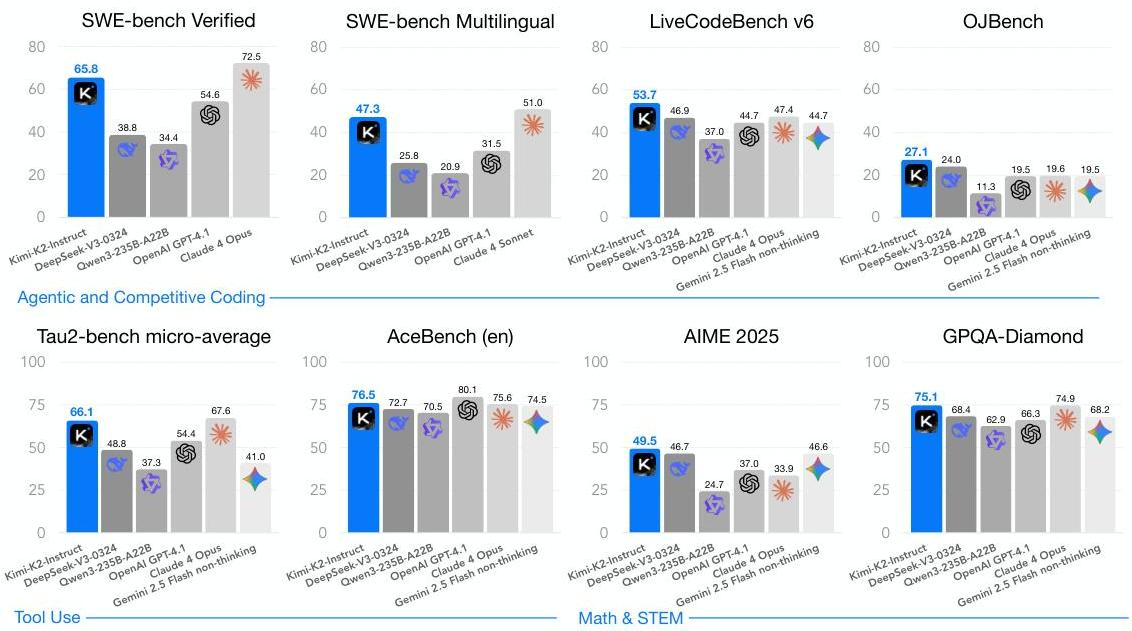
**This image shows a series of bar charts comparing the performance of various AI models across different benchmarks. The benchmarks are categorized into 'Agentic and Competitive Coding', 'Tool Use', and 'Math & STEM'. Each bar chart represents a specific benchmark, such as SWE-bench Verified, SWE-bench Multilingual, LiveCodeBench v6, OJBench, Tau2-bench micro-average, AceBench (en), AIME 2025, and GPQA-Diamond. The AI models compared include Kimi-K2-Instruct, DeepSeekV3-0324, Owen3-235B-A22B, OpenAI GPT-4.1, Claude 4 Opus, Claude 4 Sonnet, and Gemini 2.5 Flash non-thinking. Each bar chart shows the performance scores of these models, with Kimi-K2-Instruct generally performing the best across most benchmarks.**
Figure 1: Kimi K2 main results.2

In [3]:
# Display (just first page)
page_texts, metadata = process_saved_ocr_json("RAG/OCR/responses_reindexed.json", range=[0, 1], include_images=True, include_tables=True)
display(Markdown(page_texts[0]))

### 2.2 Preparing Document's text for RAG

We need another step before going into the embeddings: 

**We want to replace images and tables with a textual description for our RAG.** 

As a matter of fact, Mistral gave us descriptions for the images, which we already put in the text, but no descriptions for tables. The RAG model will have troubles reading from an html representation of a table and will get confused. 

*So we want to give the pdf of the paper, together with the extracted tables, to a multimodal model that will provide a summary of the given tables and an index. Then we swap the result in the text*.

Let's do that:

In [18]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from dotenv import load_dotenv
import os
from pydantic import BaseModel, Field, SecretStr

load_dotenv()
llm = ChatOpenAI(
    model="google/gemini-2.5-flash", 
    
    # redirect LangChain to OpenRouter
    base_url="https://openrouter.ai/api/v1",

    # pass the OpenRouter key
    api_key=SecretStr(os.environ["OPENROUTER_API_KEY"])
)

prompt = """
You are a document indexing assistant. 
I will provide a document and its corresponding OCR Markdown. 
Your task is to find every table placeholder (e.g., [tbl-x.html]) in the text, identify what that table represents, and return a JSON mapping.

Specifically, you must return an answer composed of 2 lists:
- titles: the titles of the tables, extracted from the document.
- descriptions: the descriptions of the tables. 
These descriptions must be thorough and include all the information in the table, highlighting the main points and the context.
"""

class ResponseFormat(BaseModel):
    titles : list[str] = Field("The titles of the tables, extracted from the document.")
    descriptions : list[str] = Field("The descriptions of the tables.")

agent = create_agent(
    model=llm,
    system_prompt=prompt,
    response_format=ResponseFormat,
)

In [ ]:
from langchain_core.messages import HumanMessage

# get the full text with no base64 image data but with table contents (as html)
# we want this llm to check the tables content and have full context 
full_text = process_saved_ocr_json("RAG/OCR/responses_reindexed.json", include_images=False, include_tables=True)
# we also pass the pdf in order to have full context (maybe not needed)
base64_pdf = encode_pdf("RAG/documents/KimiK2.pdf")

message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": f"Here is the structured OCR text and tables for context:\n\n{full_text}"
        },
        {
            "type": "image_url", 
            "image_url": {
                "url": f"data:application/pdf;base64,{base64_pdf}"
            }
        },
    ]
)

input_state = {"messages" : [message]}

In [ ]:
result = agent.invoke(input_state)

In [ ]:
print("-" * 40)
for i, (title, description) in enumerate(zip(result['structured_response'].titles, result['structured_response'].descriptions)):
    print(f"Table {i}:")
    print(f"Title: {title}")
    print(f"Description: {description}")
    print("-" * 40)

# save this to file in RAG/OCR/tables_descriptions.json
# Create a list of dictionaries to preserve the relationship between titles and descriptions
tables_data = [
    {
        "index": i,
        "title": title,
        "description": description
    }
    for i, (title, description) in enumerate(zip(
        result['structured_response'].titles, 
        result['structured_response'].descriptions
    ))
]

with open("RAG/OCR/tables_descriptions.json", "w") as f:
    json.dump(tables_data, f, indent=4)

----------------------------------------
Table 0:
Title: SimpleQA Accuracy under three rephrasing-epoch configurations
Description: This table compares the SimpleQA Accuracy under three different configurations related to data rephrasing and the number of training epochs. The first row shows the accuracy for raw wiki-text repeated for 10 epochs (23.76). The second row shows the accuracy for data rephrased once and repeated for 10 epochs (27.39). The third row shows the accuracy for data rephrased 10 times with a single training pass (28.94). The table demonstrates that rephrasing data leads to improved accuracy, with more rephrasing and fewer epochs yielding better results.
----------------------------------------
Table 1:
Title: Architectural comparison between Kimi K2 and DeepSeek-V3
Description: This table provides a detailed comparison of architectural parameters between Kimi K2 and DeepSeek-V3. It includes metrics such as #Layers, Total Parameters, Activated Parameters, Experts (t

Nice! now we swap these descriptions with our table indices:

In [31]:
def insert_tables_descriptions(page_text: str, tables_data: list[dict]) -> str:
    """
    Insert the tables descriptions into a page text at the correct positions.
    
    Args:
        page_text: Text of a single page
        tables_data: List of dicts with 'index', 'title', 'description'
    
    Returns:
        Page text with table placeholders replaced by descriptions
    """
    for table in tables_data:
        i = table['index']
        title = table['title']
        description = table['description']
        
        # Match the markdown link format: [tbl-0.html](tbl-0.html)
        placeholder = f"[tbl-{i}.html](tbl-{i}.html)"
        
        # Replace with placeholder link + description
        replacement = f"[tbl-{i}.html](PLACEHOLDER_tbl-{i}.html)\n**Table {i}: {title}**\n{description}"
        
        page_text = page_text.replace(placeholder, replacement)

    return page_text

# Load table descriptions
with open("RAG/OCR/tables_descriptions.json", "r") as f:
    tables_data = json.load(f)

# Get pages without images and tables (just placeholders)
page_texts, page_metadata = process_saved_ocr_json(
    "RAG/OCR/responses_reindexed.json", 
    include_images=False, 
    include_tables=False
)

> **Note:** Actually there is a common problem that i found out after everything was finished and running in part 2. We have a header that got embedded in many parts of the document, which is `"Kimi K2\n\nTECHNICAL REPORT"` and since this is separated by `\n\n` it f**ks up the text splitter. So we should clean it:

In [32]:
import re

def clean_page_text(text: str) -> str:
    """Remove the repetitive running header from pages."""
    # Pattern to match "Kimi K2" followed by newlines, followed by "TECHNICAL REPORT"
    pattern = r"^\s*Kimi K2\s+TECHNICAL REPORT\s+"
    return re.sub(pattern, "", text, flags=re.MULTILINE)

pages_with_descriptions = [
    clean_page_text(insert_tables_descriptions(page_text, tables_data)) 
    for page_text in page_texts
]

Perfect! Our text contains all the descriptions necessary for our rag, and we got the indexed images and tables separately as metadata!

In [33]:
for key in page_metadata[0].keys():
    print(key)

source
chunk_index
page_index
global_page_number
document_summary
document_authors
num_images
num_tables
image_ids
table_ids
images
tables


There is a catch: we cannot embed heavy metadata in vector stores like Chroma: they are optimized for efficient search and only accept primitive types (str, bool, int..) so what can we do? 

We separate the 'heavy' metadata from the 'lightweight' and use pages ids and images/tables indices to map them.

In [34]:
# Chiavi che il Vector Store può gestire
LIGHT_KEYS = {
    "source", 
    "chunk_index", 
    "page_index", 
    "global_page_number", 
    "num_images", 
    "num_tables"
}

# Chiavi "pesanti" o con liste 
HEAVY_KEYS = {
    "document_summary", 
    "document_authors", 
    "image_ids", 
    "table_ids", 
    "images", 
    "tables"
}

vector_metadata = []
heavy_metadata = []

for meta in page_metadata:
    # Creiamo il dizionario leggero filtrando solo le chiavi ammesse
    light = {k: v for k, v in meta.items() if k in LIGHT_KEYS}
    
    # Creiamo il dizionario pesante con tutto il resto
    heavy = {k: v for k, v in meta.items() if k in HEAVY_KEYS}

    # per connettere light e heavy aggiungiamo anche un doc_id univoco (opzionale)
    import uuid
    doc_id = str(uuid.uuid4())
    light["doc_id"] = doc_id
    heavy["doc_id"] = doc_id

    vector_metadata.append(light)
    heavy_metadata.append(heavy)

All we need to do now is convert our objects into LangChain's `Document` objects in order to be able to embed it in a vector store. Luckily, this is the easiest part.

## 3. Embedding

### 3.1 Transform into `Document`

It's this simple:

In [35]:
from langchain_core.documents import Document

# only light metadata is embedded in the vector store
documents = [
    Document(page_content=t, metadata=m)
    for t,m in zip(pages_with_descriptions, vector_metadata)
] 

Then we need to split the text in order to create the chunks for our vector store.

### 3.2 Split Text

We will use LangChain's `RecursiveCharacterTextSplitter` (check all splitters [here](https://docs.langchain.com/oss/python/integrations/splitters#text-structure-based))

In [22]:
%pip install -qU langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [36]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=300)
all_splits = text_splitter.split_documents(documents)

In [37]:
# checks
print(len(all_splits))
print(all_splits[0].page_content[:500])

111
K KIMI K2: OPEN AGENTIC INTELLIGENCE

# TECHNICAL REPORT OF KIMI K2

# Kimi Team

# ABSTRACT

We introduce Kimi K2, a Mixture-of-Experts (MoE) large language model with 32 billion activated parameters and 1 trillion total parameters. We propose the MuonClip optimizer, which improves upon Muon with a novel QK-clip technique to address training instability while enjoying the advanced token efficiency of Muon. Based on MuonClip, K2 was pre-trained on 15.5 trillion tokens with zero loss spike. Durin


### 3.3 Create Vector Store

Now we create the vector db with our chunks. We will use [Chroma](https://docs.trychroma.com/docs/overview/introduction) (it's free).

In [ ]:
%pip install -qU langchain-chroma

In [38]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
import os

chroma_dir = "RAG/chroma"
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")  

# do not recreate vector store if it already exists (!)
if os.path.exists(chroma_dir):
    raise ValueError("Vector store already exists!")

os.makedirs(chroma_dir, exist_ok=True)
vector_store = Chroma.from_documents(
    documents=all_splits,
    embedding=embeddings,
    persist_directory=chroma_dir
)

In [39]:
retrieved_docs = vector_store.similarity_search("Comparison between Kimi K2 and deepseek")
retrieved_docs

[Document(id='857c783e-ea81-41f8-9de2-e4d80093795f', metadata={'global_page_number': 15, 'source': 'RAG/OCR/responses_reindexed.json', 'doc_id': 'f795e62d-e7be-4cf5-8bca-02b12f84476d', 'num_images': 0, 'chunk_index': 1, 'num_tables': 1, 'page_index': 7}, page_content="Table 3: Performance comparison of Kimi-K2-Instruct against leading open-source and proprietary models across diverse tasks. Bold denotes the global SOTA; underlined bold indicates the best open-source result. Data points marked with * are taken directly from the model's technical report or blog.\n\n[tbl-2.html](PLACEHOLDER_tbl-2.html)"),
 Document(id='939c6ebe-2165-44a8-b5ba-00b66552e910', metadata={'num_images': 0, 'page_index': 1, 'chunk_index': 0, 'source': 'RAG/OCR/responses_reindexed.json', 'num_tables': 0, 'doc_id': 'daca2d6a-0421-4803-b613-82b2cae8381c', 'global_page_number': 1}, page_content='Kimi K2 demonstrates strong performance across a broad spectrum of agentic and frontier benchmarks. It achieves scores of 

All right! We finished the first part of our RAG system, which is the most tiring and difficult actually. The next steps are all in LangGraph, we'll see them in the next notebook.

Let's just save the heavy metadata that was not embedded: 

In [40]:
import os
os.makedirs("RAG/OCR", exist_ok=True)
with open("RAG/OCR/heavy_metadata.json", "w") as f:
    json.dump(heavy_metadata, f, indent=4)